# **SVM model training and validation**

In [2]:
!pip install biopython
!pip install aaindex

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import sklearn.metrics as skl
import seaborn as sns
import math
import io
import warnings
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from Bio.SeqUtils.ProtParam import ProteinAnalysis, ProtParamData
from aaindex import aaindex1
from sklearn.metrics import matthews_corrcoef, accuracy_score, precision_score, recall_score, confusion_matrix, roc_curve, auc, precision_recall_curve, average_precision_score
sys.path.append('../shared_code')
import Data_analysis as da
import Von_Heijne_model as vh

# **Features extraction**



In [5]:
# Import the training set
training = pd.read_csv("../2_data_preparation/sets/train_with_seq.tsv", sep='\t')
training.head()

,id,organism_name,kingdom,sequence_length,cleavage_site,validation_n,sp_type,transmembrane,sequence
0,Q99MA2,Rattus norvegicus,Metazoa,674,22.0,3,1,NaN,MAQAYWQCYPWLVLLCACAWSYPGPESLGREDVRDCSTNPPRLPVT...
1,P17948,Homo sapiens,Metazoa,1338,26.0,1,1,NaN,MVSYWDTGVLLCALLSCLLLTGSSSGSKLKDPELSLKGTQHIMQAG...
2,P41271,Homo sapiens,Metazoa,181,16.0,1,1,NaN,MMLRVLVGAVLPAMLLAAPPPINKLALFPDKSAWCEAKNITQIVGH...
3,Q8I948,Acanthoscurria gomesiana,Metazoa,156,23.0,4,1,NaN,MAFRMKLVVCIVLLSTLAVMSSADVYKGGGGGRYGGGRYGGGGGYG...
4,Q92154,Coturnix japonica,Metazoa,620,17.0,4,1,NaN,MELLVLTVLLMGTGCISAPWAAWMPPKMAALSGTCVQLPCRFDYPE...


In [6]:
# Import the benchmarking set
benchmark = pd.read_csv("../2_data_preparation/sets/test_with_seq.tsv", sep='\t')
benchmark.head()

,id,organism_name,kingdom,sequence_length,cleavage_site,sp_type,transmembrane,sequence
0,A0A1S6EK92,Moringa oleifera,Viridiplantae,79,20.0,1,NaN,MAKLSFLSLFLLCLVATATAQNCGRQAGNRACANGLCCSQYGFCGS...
1,P19801,Homo sapiens,Metazoa,751,19.0,1,NaN,MPALGWAVAAILMLQTAMAEPSPGTLPRKAGVFSDLSNQELKAVHS...
2,P79263,Sus scrofa,Metazoa,921,27.0,1,NaN,MKTLSPTGYGLLLVLPLLLAVLQSTTAHKNDINIYSLTVDSKVSSR...
3,P21814,Ovis aries,Metazoa,429,25.0,1,NaN,MSHRRMQLALSLVFILCGLFNSIFCEKQQHSQQHANLVLLKKISAF...
4,P29421,Oryza sativa subsp. japonica,Viridiplantae,200,22.0,1,NaN,MVSLRLPLILLSLLAISFSCSAAPPPVYDTEGHELSADGSYYVLPA...


In [7]:
# Assign a numeric index to each aminoacid
index_aa = vh.index_aa
print(index_aa)

{'A': 0, 'R': 1, 'N': 2, 'D': 3, 'C': 4, 'Q': 5, 'E': 6, 'G': 7, 'H': 8, 'I': 9, 'L': 10, 'K': 11, 'M': 12, 'F': 13, 'P': 14, 'S': 15, 'T': 16, 'W': 17, 'Y': 18, 'V': 19}


In [8]:
def aa_composition(sequence, length: int, index_aa):
  ''' Calculate the aminoacid frequency of a sequence of a given length
  '''
  sequence = sequence[:length]
  freq = np.zeros((1, 20))
  for aa in sequence:
    if aa in index_aa.keys():
      freq[0,index_aa[aa]] += 1
  freq = np.round(freq/len(sequence), 3)
  return freq

# Calculate the aminoacid composition for each sequence of the dataframe and save it into a unique numpy matrix
aa_comp = np.vstack(training['sequence'].apply(aa_composition, args=(22, index_aa)))
aa_comp_test = np.vstack(benchmark['sequence'].apply(aa_composition, args=(22, index_aa)))

In [9]:
def shannon_entropy(seq, window: int):
    """Calculates the Shannon entropy on a given window of residues"""
    seq = seq[:window]
    L = len(seq)
    if L == 0:
        return 0
    freqs = {aa: seq.count(aa) / L for aa in set(seq)}
    H = -sum(p * math.log2(p) for p in freqs.values())
    return H

# Calculate the Shannon entropy for each sequence of the dataframe and save it into a unique numpy matrix
shan_ent = np.vstack(training['sequence'].apply(lambda seq: shannon_entropy(seq, 30)))
shan_ent_test = np.vstack(benchmark['sequence'].apply(lambda seq: shannon_entropy(seq, 30)))

In [10]:
# Calculate the scores given by the application of the Von Heijne algorithm for each sequence of the dataframe and save it into a unique numpy matrix
training_pos = training.loc[training['sp_type']==1].copy()
swiss_freq = da.swiss_freq
training_pos['sp_cut'] = training_pos.apply(da.cut_sp_sequence_logo, axis=1)
pswm = vh.von_Heijne_matrix(training_pos, 15, swiss_freq, index_aa)
score_vh = np.vstack(training['sequence'].apply(lambda seq: vh.best_score_calculator(seq, 90, 15, pswm, index_aa)))
score_vh_test = np.vstack(benchmark['sequence'].apply(lambda seq: vh.best_score_calculator(seq, 90, 15, pswm, index_aa)))

In [11]:
def hydrophobicity(sequence, window: int, length: int):
    """Calculates hydrophobicity ignoring Biopython warnings about non-standard amino acids."""
    sequence = sequence[:length]
    d = int(window / 2)
    sequence_with_padding = "X" * d + sequence + "X" * d
    # hyde warning messages
    stderr_backup = sys.stderr
    sys.stderr = io.StringIO()
    try:
        seq_padding = ProteinAnalysis(sequence_with_padding)
        kd_pos_with_padding = seq_padding.protein_scale(ProtParamData.kd, window)
    finally:
        sys.stderr = stderr_backup  
    return kd_pos_with_padding

# Calculate the hydrophobicity of the first 40 residues for each sequence and save it into a unique matrix numpy
hydro = np.vstack(training['sequence'].apply(hydrophobicity, args=(5,40)))
hydro_test = np.vstack(benchmark['sequence'].apply(hydrophobicity, args=(5,40)))

In [12]:
feature_codes = {
    "net_charge": ("KLEP840101", 2),
    "hydrophilicity": ("HOPT810101", 5),
    "helix_propensity": ("CHAM830101",7),
    "beta_sheet_propensity": ("CHOP780202", 7),
    "flexibility": ("BHAR880101", 7),
    "isoelectric_point": ("ZIMJ680104", 2),
    "bulkiness": ("ZIMJ680102", 7)
}

def feature_to_array(sequence, length: int, feature_code, window: int):
    """Creates an array [mean, std, max] for a given AAindex feature,
    suppressing Biopython's non-standard amino acid warnings without altering the sequence."""
    
    sequence = sequence[:length]
    vals = aaindex1[feature_code].values

    # Hides temporarily the warnong messages 
    stderr_backup = sys.stderr
    sys.stderr = io.StringIO()
    try:
        seq = ProteinAnalysis(sequence)
        val = seq.protein_scale(vals, window)
    finally:
        sys.stderr = stderr_backup  # Restore the original stderr 

    mean = np.mean(val)
    std = np.std(val)
    max_val = np.max(val)

    return np.round([mean, std, max_val], 3)

# Create a dictionary with an array for each feature selected by the feature extraction (in both training and benchmarking set)
feats = {}
for feature in feature_codes.keys():
  feats[feature] = np.vstack(training['sequence'].apply(feature_to_array, args=(30, feature_codes[feature][0], feature_codes[feature][1])))

test_feat = {}
for feature in feature_codes.keys():
  test_feat[feature] = np.vstack(benchmark['sequence'].apply(feature_to_array, args=(30, feature_codes[feature][0], feature_codes[feature][1])))

# Save the arrays in .npz files with all the features concatenated
np.savez('../5_SVM/npz_files/separate_features.npz', aa_comp = aa_comp, score = score_vh, shann_ent=shan_ent, hydrophobicity = hydro, **feats)
np.savez('../5_SVM/npz_files/test_features.npz', aa_comp= aa_comp_test, score = score_vh_test, shann_ent=shan_ent_test, hydrophobicity = hydro_test, **test_feat)

In [13]:
# Create a dataframe from the loaded features, handling multi-dimensional arrays (again for both training and test set)
def npz_to_dataframe(npz_file):
    '''
        Creates a dataframe from a .npz format file handling also multidimensional arrays
    '''
    matrices = np.load(npz_file)
    data = {}
    for key in matrices.files:
        arr = matrices[key]
        if arr.ndim > 1:
          # If the array is multi-dimensional, create multiple columns
            for i in range(arr.shape[1]):
                data[f'{key}_{i+1}'] = arr[:, i]
        else:
          # If the array is 1-dimensional, use it directly
            data[key] = arr
    X = pd.DataFrame(data)
    return X, data

X, data = npz_to_dataframe("../5_SVM/npz_files/separate_features.npz")
T = npz_to_dataframe("../5_SVM/npz_files/test_features.npz")[0]
Y_T = benchmark["sp_type"]

In [14]:
# Add the validation and id columns to subsequently divide the dataset during the cross-validation runs
X["id"] = training["id"]
X["validation_n"] = training["validation_n"]
y = training["sp_type"]
X.head()

,aa_comp_1,aa_comp_2,aa_comp_3,aa_comp_4,aa_comp_5,aa_comp_6,aa_comp_7,aa_comp_8,aa_comp_9,aa_comp_10,...,flexibility_2,flexibility_3,isoelectric_point_1,isoelectric_point_2,isoelectric_point_3,bulkiness_1,bulkiness_2,bulkiness_3,id,validation_n
0,0.182,0.000,0.0,0.000,0.136,0.091,0.000,0.000,0.0,0.000,...,0.046,0.499,5.844,0.744,9.163,15.949,2.369,20.414,Q99MA2,3
1,0.045,0.000,0.0,0.045,0.091,0.000,0.000,0.091,0.0,0.000,...,0.043,0.512,5.919,0.862,8.487,14.830,2.777,18.876,P17948,1
2,0.182,0.045,0.0,0.000,0.000,0.000,0.000,0.045,0.0,0.045,...,0.029,0.469,6.202,0.890,9.167,16.859,0.937,18.960,P41271,1
3,0.091,0.045,0.0,0.000,0.045,0.000,0.000,0.000,0.0,0.045,...,0.027,0.488,6.171,1.044,9.000,16.351,2.594,20.339,Q8I948,4
4,0.136,0.000,0.0,0.000,0.045,0.000,0.045,0.091,0.0,0.045,...,0.026,0.458,5.952,0.680,8.593,16.017,2.508,20.644,Q92154,4


# **Feature selection with RFE (Recursive Feature Elimination) and model training with SVM (Support Vector Machine)**

For each cross-validation fold made with different combination of train, validation and test sets:
*  Train an SVM baseline on all features.
*  Rank features by importance using a Random Forest.
*  Determine the optimal number of top features (k) using validation accuracy curves.
*  Retrain an SVM using only the top-k features.
*  Compare test accuracy with and without feature selection.
*  Save all datasets (.npz), plots, and results to allow reproducibility.

In [16]:
# Create an order for the different combination of sets of the cross-validation step
groups = vh.make_groups()
print(groups)

1 2 3 4 5
2 3 4 5 1
3 4 5 1 2
4 5 1 2 3
5 1 2 3 4
{'Run_1': ((1, 2, 3), 4, 5), 'Run_2': ((2, 3, 4), 5, 1), 'Run_3': ((3, 4, 5), 1, 2), 'Run_4': ((4, 5, 1), 2, 3), 'Run_5': ((5, 1, 2), 3, 4)}


In [17]:
def svm_pipeline(C, gamma):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(kernel="rbf", C=C, gamma=gamma, random_state=42))
    ])

def accuracy_on_subset(C, gamma, subset_features):
    # subset by feature names
    # Convert data keys to a NumPy array for use with np.where
    data_keys_np = np.array(list(data.keys()))
    idx = [np.where(data_keys_np == f)[0][0] for f in subset_features]
    Xtr = X_train.iloc[:, idx]
    Xva = X_val.iloc[:, idx]
    pipe = svm_pipeline(C, gamma)
    pipe.fit(Xtr, y_train)     # train on TRAIN only
    return pipe.score(Xva, y_val)  # accuracy on VALIDATION


In [18]:
def grid_search(C_grid, gamma_grid, X_train, Y_train, X_val, Y_val):
    '''
        Selects the best scores and the best params by training a SVM model on given train and validation sets
    '''
    best_score = -np.inf
    best_params = None

    for C in C_grid:
        for gamma in gamma_grid:
            pipe = svm_pipeline(C, gamma)
            pipe.fit(X_train, Y_train)
            val_acc = pipe.score(X_val, Y_val)
            if val_acc > best_score:
                best_score = val_acc
                best_params = {"C": C, "gamma": gamma}

    return best_score, best_params


=== RUN_1 ===
Train: (1, 2, 3), Val: 4, Test: 5
0.978 with params {'C': 1.0, 'gamma': 'scale'}
Top 10 features by Gini importance:
             feature  importance
0            score_1        0.14
1   hydrophilicity_1        0.08
2  hydrophobicity_11        0.05
3  hydrophobicity_12        0.05
4        bulkiness_3        0.05
5  hydrophobicity_10        0.05
6  hydrophobicity_13        0.04
7      flexibility_1        0.04
8   hydrophobicity_9        0.04
9         aa_comp_11        0.04


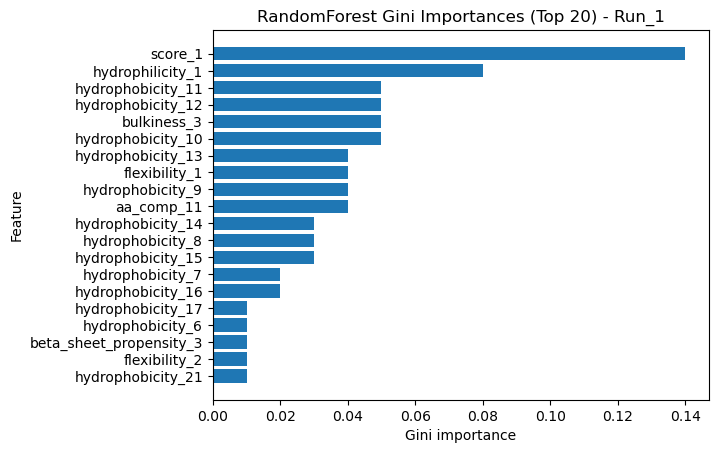

Best k on validation (using baseline best params): k=23, val_acc=0.978


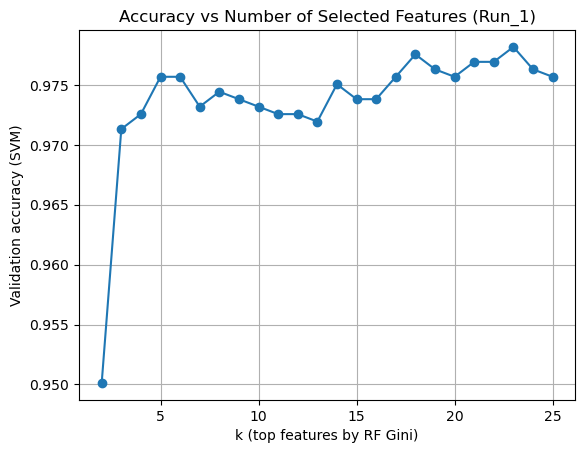


--- RESULTS SUMMARY ---
Best validation accuracy (after feature selection): 0.98
   → Found with parameters: C = 10.0, gamma = 0.01

Final test accuracy (using selected features): 0.98
Final test accuracy (using all features - baseline model): 0.98

 The baseline model (all features) performs slightly better on the test set.

=== SVM with FEATURE SELECTION ===
MCC = 0.88 | ACC = 0.98 | PPV = 0.85 | SEN = 0.94 | F1_SCORE = 0.89
Confusion Matrix:
 [[1402   28]
 [  11  164]]

=== SVM with ALL FEATURES (BASELINE) ===
MCC = 0.89 | ACC = 0.98 | PPV = 0.86 | SEN = 0.94 | F1_SCORE = 0.90
Confusion Matrix:
 [[1403   27]
 [  10  165]]
               Model   MCC   ACC   PPV   SEN  F1_SCORE
0  Selected features  0.88  0.98  0.85  0.94      0.89
1       All features  0.89  0.98  0.86  0.94      0.90

=== RUN_2 ===
Train: (2, 3, 4), Val: 5, Test: 1
0.977 with params {'C': 1.0, 'gamma': 'scale'}
Top 10 features by Gini importance:
             feature  importance
0            score_1        0.13
1  

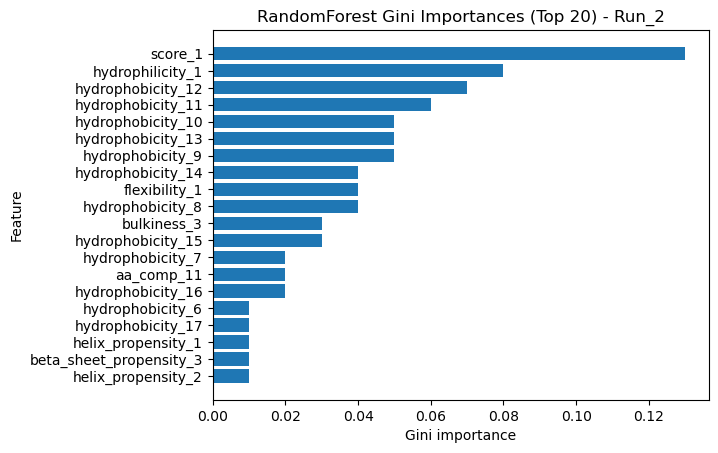

Best k on validation (using baseline best params): k=22, val_acc=0.975


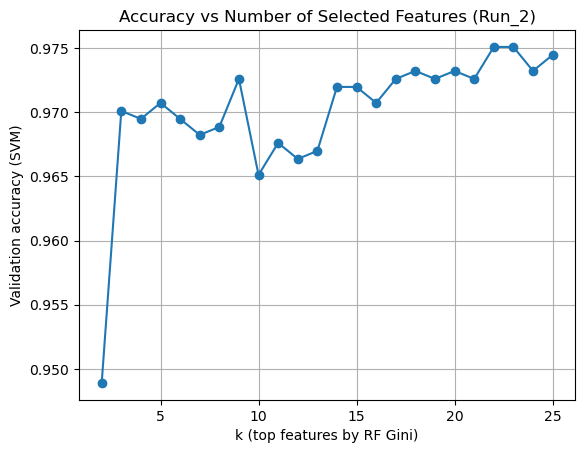


--- RESULTS SUMMARY ---
Best validation accuracy (after feature selection): 0.98
   → Found with parameters: C = 10.0, gamma = 0.01

Final test accuracy (using selected features): 0.98
Final test accuracy (using all features - baseline model): 0.98

 The model with selected features performs the same as the baseline.

=== SVM with FEATURE SELECTION ===
MCC = 0.87 | ACC = 0.98 | PPV = 0.90 | SEN = 0.87 | F1_SCORE = 0.88
Confusion Matrix:
 [[1413   17]
 [  23  152]]

=== SVM with ALL FEATURES (BASELINE) ===
MCC = 0.87 | ACC = 0.98 | PPV = 0.90 | SEN = 0.87 | F1_SCORE = 0.88
Confusion Matrix:
 [[1413   17]
 [  23  152]]
               Model   MCC   ACC  PPV   SEN  F1_SCORE
0  Selected features  0.87  0.98  0.9  0.87      0.88
1       All features  0.87  0.98  0.9  0.87      0.88

=== RUN_3 ===
Train: (3, 4, 5), Val: 1, Test: 2
0.973 with params {'C': 1.0, 'gamma': 'scale'}
Top 10 features by Gini importance:
             feature  importance
0            score_1        0.11
1  hydrophobic

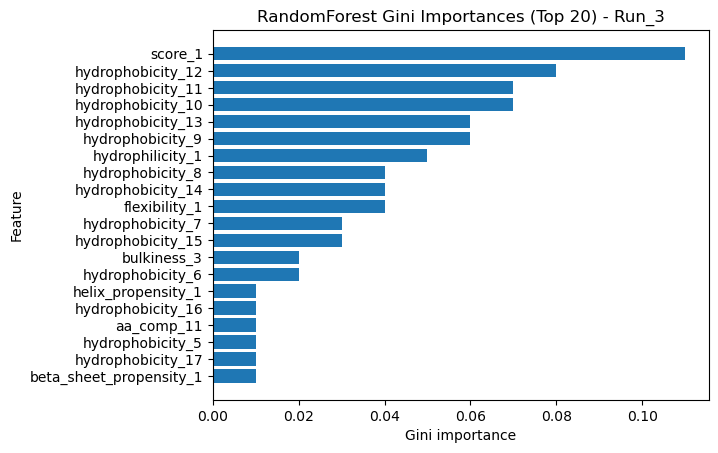

Best k on validation (using baseline best params): k=22, val_acc=0.971


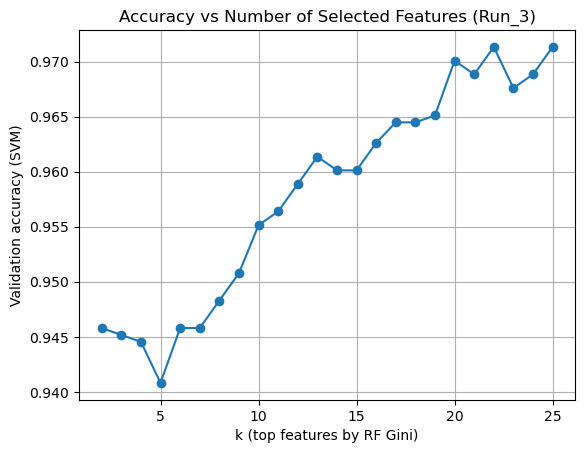


--- RESULTS SUMMARY ---
Best validation accuracy (after feature selection): 0.97
   → Found with parameters: C = 1.0, gamma = scale

Final test accuracy (using selected features): 0.96
Final test accuracy (using all features - baseline model): 0.97

 The baseline model (all features) performs slightly better on the test set.

=== SVM with FEATURE SELECTION ===
MCC = 0.80 | ACC = 0.96 | PPV = 0.88 | SEN = 0.76 | F1_SCORE = 0.82
Confusion Matrix:
 [[1411   18]
 [  42  133]]

=== SVM with ALL FEATURES (BASELINE) ===
MCC = 0.83 | ACC = 0.97 | PPV = 0.92 | SEN = 0.78 | F1_SCORE = 0.84
Confusion Matrix:
 [[1417   12]
 [  39  136]]
               Model   MCC   ACC   PPV   SEN  F1_SCORE
0  Selected features  0.80  0.96  0.88  0.76      0.82
1       All features  0.83  0.97  0.92  0.78      0.84

=== RUN_4 ===
Train: (4, 5, 1), Val: 2, Test: 3
0.974 with params {'C': 10.0, 'gamma': 'scale'}
Top 10 features by Gini importance:
             feature  importance
0            score_1        0.11
1 

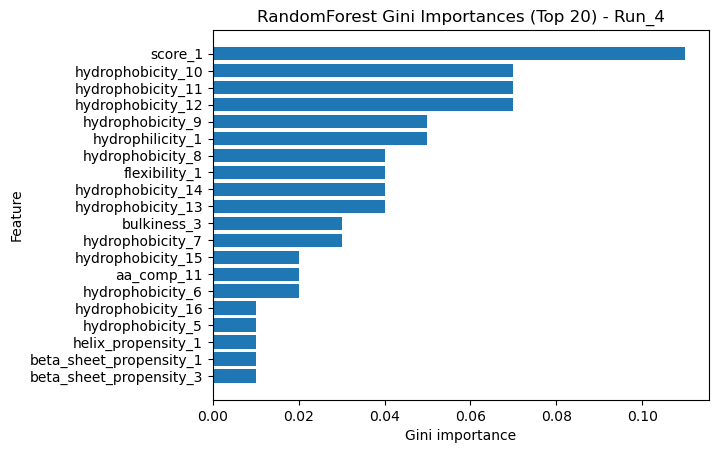

Best k on validation (using baseline best params): k=22, val_acc=0.970


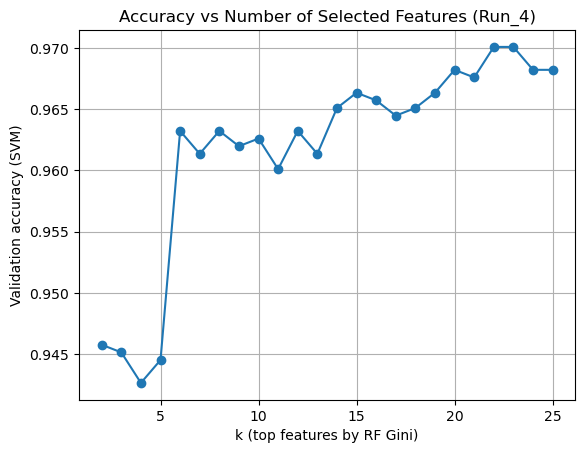


--- RESULTS SUMMARY ---
Best validation accuracy (after feature selection): 0.97
   → Found with parameters: C = 10.0, gamma = scale

Final test accuracy (using selected features): 0.97
Final test accuracy (using all features - baseline model): 0.98

 The baseline model (all features) performs slightly better on the test set.

=== SVM with FEATURE SELECTION ===
MCC = 0.85 | ACC = 0.97 | PPV = 0.91 | SEN = 0.82 | F1_SCORE = 0.86
Confusion Matrix:
 [[1414   15]
 [  31  143]]

=== SVM with ALL FEATURES (BASELINE) ===
MCC = 0.88 | ACC = 0.98 | PPV = 0.90 | SEN = 0.88 | F1_SCORE = 0.89
Confusion Matrix:
 [[1412   17]
 [  21  153]]
               Model   MCC   ACC   PPV   SEN  F1_SCORE
0  Selected features  0.85  0.97  0.91  0.82      0.86
1       All features  0.88  0.98  0.90  0.88      0.89

=== RUN_5 ===
Train: (5, 1, 2), Val: 3, Test: 4
0.979 with params {'C': 1.0, 'gamma': 'scale'}
Top 10 features by Gini importance:
             feature  importance
0            score_1        0.13
1 

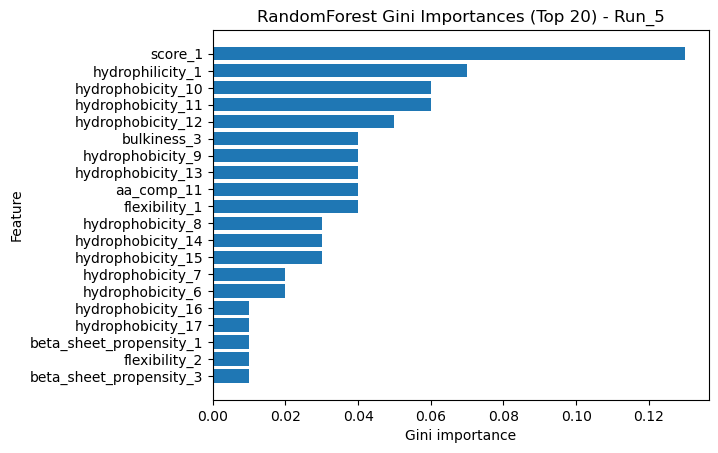

Best k on validation (using baseline best params): k=5, val_acc=0.973


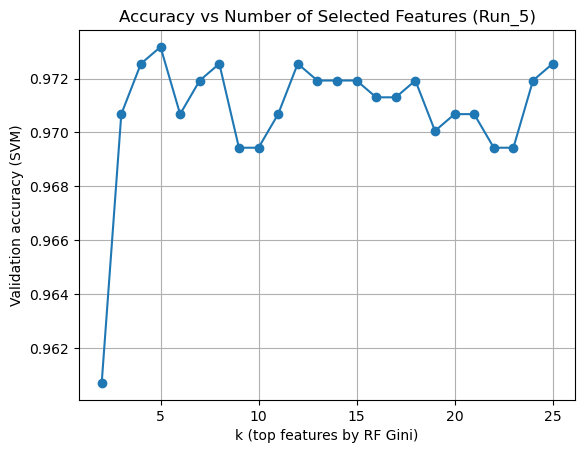


--- RESULTS SUMMARY ---
Best validation accuracy (after feature selection): 0.97
   → Found with parameters: C = 1.0, gamma = 0.1

Final test accuracy (using selected features): 0.97
Final test accuracy (using all features - baseline model): 0.98

 The baseline model (all features) performs slightly better on the test set.

=== SVM with FEATURE SELECTION ===
MCC = 0.86 | ACC = 0.97 | PPV = 0.85 | SEN = 0.90 | F1_SCORE = 0.88
Confusion Matrix:
 [[1401   28]
 [  17  158]]

=== SVM with ALL FEATURES (BASELINE) ===
MCC = 0.89 | ACC = 0.98 | PPV = 0.91 | SEN = 0.89 | F1_SCORE = 0.90
Confusion Matrix:
 [[1414   15]
 [  20  155]]
               Model   MCC   ACC   PPV   SEN  F1_SCORE
0  Selected features  0.86  0.97  0.85  0.90      0.88
1       All features  0.89  0.98  0.91  0.89      0.90


In [19]:
results = []
# Define search grids for SVM hyperparameters C and gamma.
C_grid = [0.1, 1.0, 10.0, 100.0]
gamma_grid = ["scale", 0.01, 0.1, 1.0]

all_metric_sel = []
all_metric_all = []
best_features = []
# Each iteration corresponds to one cross-validation fold.
# For each fold, we define TRAIN, VALIDATION, and TEST sets based on validation_n values.
for name, (train_idx, val_idx, test_idx) in groups.items():
    print(f"\n=== {name.upper()} ===")
    print(f"Train: {train_idx}, Val: {val_idx}, Test: {test_idx}")
    warnings.filterwarnings("ignore", message="X has feature names")
    # Filter the main dataset (X and y) according to the fold indices.
    # Drop non-numerical or identifier columns such as 'id' and 'validation_n'.
    X_train = X[X["validation_n"].isin(train_idx)].drop(columns=["id", "validation_n"])
    X_val   = X[X["validation_n"].isin([val_idx])].drop(columns=["id", "validation_n"])
    X_test  = X[X["validation_n"].isin([test_idx])].drop(columns=["id", "validation_n"])

    y_train = y[training["validation_n"].isin(train_idx)]
    y_val   = y[training["validation_n"].isin([val_idx])]
    y_test  = y[training["validation_n"].isin([test_idx])]

    # Convert the DataFrames into NumPy arrays and save them in a single .npz file.
    # This stores all matrices for the current fold (train, validation, test) in one place.

    X_train_np = X_train.to_numpy()
    X_val_np = X_val.to_numpy()
    X_test_np = X_test.to_numpy()

    y_train_np = y_train.to_numpy()
    y_val_np = y_val.to_numpy()
    y_test_np = y_test.to_numpy()

    np.savez(
        f"../5_SVM/npz_files/cv_set_{name}.npz",
        X_train=X_train_np,
        X_val=X_val_np,
        X_test=X_test_np,
        y_train=y_train_np,
        y_val=y_val_np,
        y_test=y_test_np
    )

    # Perform a manual grid search over C and gamma values.
    # Evaluate each model on the VALIDATION set and store the best parameters.

    best_score_base, best_params_base = grid_search(
    C_grid, gamma_grid,
    X_train.to_numpy(), y_train.to_numpy(),
    X_val.to_numpy(), y_val.to_numpy())
    print( f"{best_score_base:.3f} with params {best_params_base}")


    # Train a Random Forest classifier on the training data.
    # Use the Gini importance to rank features by their predictive power.
    rf = RandomForestClassifier(n_estimators=400,random_state=42,n_jobs=-1)
    rf.fit(X_train, y_train)

    gini_imp = pd.Series(rf.feature_importances_, index=list(data.keys())).sort_values(ascending=False)
    gini_df = gini_imp.reset_index()
    gini_df.columns = ["feature", "importance"]
    gini_df["importance"] = gini_df["importance"].round(2)
    print("Top 10 features by Gini importance:")
    print(gini_df.head(10))

    for i in range(0,10):
        best_features.append(gini_df['feature'][i])

    # Visualize the 20 most important features as determined by the Random Forest.
    # Save the figure for documentation of this fold.
    plt.figure()
    plt.barh(gini_df["feature"].head(20)[::-1], gini_df["importance"].head(20)[::-1])
    plt.xlabel("Gini importance")
    plt.ylabel("Feature")
    plt.title(f"RandomForest Gini Importances (Top 20) - {name}")
    plt.savefig(f"../5_SVM/ranked_features/gini_importances_{name}.png", dpi=300, bbox_inches="tight")
    plt.show()

    # Test multiple subsets of top-k features ranked by Gini importance.
    # For each subset size, evaluate the validation accuracy of the baseline SVM.
    ks = list(range(2, min(26, X_train.shape[1]+1)))  # keep it small for speed/clarity
    curve = []

    for k in ks:
        subset = gini_df["feature"].head(k).tolist()
        acc_k = accuracy_on_subset(best_params_base["C"], best_params_base["gamma"], subset)
        curve.append(acc_k)

    best_k_idx = int(np.argmax(curve))
    best_k = ks[best_k_idx]
    print(f"Best k on validation (using baseline best params): k={best_k}, val_acc={curve[best_k_idx]:.3f}")

    # Visualize how validation accuracy changes with different numbers of features.
    # The best k will correspond to the peak of the curve.
    plt.figure()
    plt.plot(ks, curve, marker="o")
    plt.xlabel("k (top features by RF Gini)")
    plt.ylabel("Validation accuracy (SVM)")
    plt.title(f"Accuracy vs Number of Selected Features ({name})")
    plt.grid(True)
    plt.savefig(f"../5_SVM/features_accuracy/accuracy_vs_features_{name}.png", dpi=300, bbox_inches="tight")
    plt.show()


    # Keep only the best_k features and re-run the grid search to find new optimal parameters.
    best_subset = gini_df["feature"].head(best_k).tolist()
    data_keys_np = np.array(list(data.keys()))
    idx = [np.where(data_keys_np == f)[0][0] for f in best_subset]

    Xtr_sel = X_train.iloc[:, idx]
    Xva_sel = X_val.iloc[:, idx]
    Xte_sel = X_test.iloc[:, idx]

    best_score_sel, best_params_sel = grid_search(
    C_grid, gamma_grid,
    Xtr_sel.to_numpy(), y_train.to_numpy(),
    Xva_sel.to_numpy(), y_val.to_numpy())
    final_pipe = svm_pipeline(best_params_sel["C"], best_params_sel["gamma"])
    final_pipe.fit(Xtr_sel.to_numpy(), y_train.to_numpy())
    test_acc = final_pipe.score(Xte_sel.to_numpy(), y_test.to_numpy())

    # For comparison: test accuracy with all features using baseline best params
    baseline_pipe = svm_pipeline(best_params_base["C"], best_params_base["gamma"])
    baseline_pipe.fit(X_train.to_numpy(), y_train.to_numpy())
    test_acc_all = baseline_pipe.score(X_test.to_numpy(), y_test.to_numpy())


    print("\n--- RESULTS SUMMARY ---")
    print(f"Best validation accuracy (after feature selection): {best_score_sel:.2f}")
    print(f"   → Found with parameters: C = {best_params_sel['C']}, gamma = {best_params_sel['gamma']}")

    print(f"\nFinal test accuracy (using selected features): {test_acc:.2f}")
    print(f"Final test accuracy (using all features - baseline model): {test_acc_all:.2f}")

    if test_acc > test_acc_all:
      print("\n The model with feature selection performs slightly better on the test set.")
    elif test_acc == test_acc_all:
      print("\n The model with selected features performs the same as the baseline.")
    else:
      print("\n The baseline model (all features) performs slightly better on the test set.")


    #METRICS
    y_pred_sel = final_pipe.predict(Xte_sel)
    y_pred_all = baseline_pipe.predict(X_test)

    obs_test = y_test

    MCC_sel, ACC_sel, PPV_sel, SEN_sel, CONF_sel, F1_SCORE_sel= vh.metrics(obs_test, y_pred_sel)
    all_metric_sel.append([MCC_sel, ACC_sel,  PPV_sel, SEN_sel, F1_SCORE_sel])

    MCC_all, ACC_all, PPV_all, SEN_all, CONF_all, F1_SCORE_all = vh.metrics(obs_test, y_pred_all)
    all_metric_all.append([MCC_all, ACC_all, PPV_all, SEN_all, F1_SCORE_all])

    print("\n=== SVM with FEATURE SELECTION ===")
    print(f"MCC = {MCC_sel:.2f} | ACC = {ACC_sel:.2f} | PPV = {PPV_sel:.2f} | SEN = {SEN_sel:.2f} | F1_SCORE = {F1_SCORE_sel:.2f}")
    print("Confusion Matrix:\n", CONF_sel)

    print("\n=== SVM with ALL FEATURES (BASELINE) ===")
    print(f"MCC = {MCC_all:.2f} | ACC = {ACC_all:.2f} | PPV = {PPV_all:.2f} | SEN = {SEN_all:.2f} | F1_SCORE = {F1_SCORE_all:.2f}")
    print("Confusion Matrix:\n", CONF_all)

    results = pd.DataFrame({
    'Model': ['Selected features', 'All features'],
    'MCC': [MCC_sel, MCC_all],
    'ACC': [ACC_sel, ACC_all],
    'PPV': [PPV_sel, PPV_all],
    'SEN': [SEN_sel, SEN_all],
    'F1_SCORE': [F1_SCORE_sel, F1_SCORE_all]
    })

    print(results.round(2))

In [20]:
# Retrieve the features selected in at least three of the five runs of cross-validation
top_features = []
for i in best_features:
    c = best_features.count(i)
    if c == 5 and i not in top_features:
        top_features.append(i)
print(top_features)

['score_1', 'hydrophilicity_1', 'hydrophobicity_11', 'hydrophobicity_12', 'hydrophobicity_10', 'hydrophobicity_13', 'flexibility_1', 'hydrophobicity_9']


In [21]:
#msd for the metric with all the features
arr_all = np.array(all_metric_all)
mean_all = np.mean(arr_all, axis=0)
std_all = np.std(arr_all, axis=0)

#mean and st for the metrics with selected features
arr_sel = np.array(all_metric_sel)
mean_sel = np.mean(arr_sel, axis=0)
std_sel = np.std(arr_sel, axis=0)

print("\n=== FEATURE SELECTION ===")
for name, mean, se in zip(["MCC","ACC","PPV","SEN", "F1 SCORE"], mean_sel, std_sel):
    print(f"{name} = {mean:.2f} ± {se:.2f}")

print("\n=== ALL FEATURES ===")
for name, mean, se in zip(["MCC","ACC","PPV","SEN","F1 SCORE"], mean_all, std_all):
    print(f"{name} = {mean:.2f} ± {se:.2f}")


=== FEATURE SELECTION ===
MCC = 0.85 ± 0.03
ACC = 0.97 ± 0.00
PPV = 0.88 ± 0.02
SEN = 0.86 ± 0.06
F1 SCORE = 0.87 ± 0.03

=== ALL FEATURES ===
MCC = 0.87 ± 0.02
ACC = 0.97 ± 0.00
PPV = 0.90 ± 0.02
SEN = 0.87 ± 0.05
F1 SCORE = 0.88 ± 0.02


# **Evaluation on the benchmarking set**

In [23]:
# Re-splitting the training set to use one subset for validation and four for training, in order to select the optimal threshold for the benchmark set.
train_indexes = [1,2,3,4]
x_training = X[X['validation_n'].isin(train_indexes)].drop(columns=["id", "validation_n"])
y_training = training["sp_type"][training['validation_n'].isin(train_indexes)]
x_validation = X[X['validation_n']==5].drop(columns=["id", "validation_n"])
y_validation = training["sp_type"].loc[training['validation_n']==5]

In [24]:
data_keys_np = np.array(list(data.keys()))
idx = [np.where(data_keys_np == f)[0][0] for f in top_features]
x_tr_sel = x_training.iloc[:, idx]
x_va_sel = x_validation.iloc[:, idx]
x_te_sel = T.iloc[:, idx]

In [105]:
# Calculate the best score and the best params with the new train and validation sets
best_score_sels, best_params_sels = grid_search(C_grid, gamma_grid, x_tr_sel.to_numpy(), y_training.to_numpy(),x_va_sel.to_numpy(), y_validation.to_numpy())
print( f"{best_score_sels:.2f} with params {best_params_sels}")
best_score, best_params = grid_search(C_grid, gamma_grid, x_training.to_numpy(), y_training.to_numpy(),x_validation.to_numpy(), y_validation.to_numpy())
print( f"{best_score:.2f} with params {best_params}")

# train the final model and test it on the benchmark set with feature selection
final_pipeline_sel = svm_pipeline(best_params_sels["C"], best_params_sels["gamma"])
final_pipeline_sel.fit(x_tr_sel.to_numpy(), y_training.to_numpy())
test_accuracy = final_pipeline_sel.score(x_te_sel.to_numpy(), Y_T.to_numpy())
# train the final model and test it on the benchmark set
final_pipeline = svm_pipeline(best_params["C"], best_params["gamma"])
final_pipeline.fit(x_training.to_numpy(), y_training.to_numpy())
test_acc = final_pipeline.score(T.to_numpy(), Y_T.to_numpy())

0.97 with params {'C': 100.0, 'gamma': 0.01}
0.98 with params {'C': 10.0, 'gamma': 'scale'}


In [151]:
set(x_te_sel.index) == set(Y_T.index)

True

In [149]:
predictions = pd.Series(y_predictions)
benchmark['predictions'] = predictions
benchmark.head()

,id,organism_name,kingdom,sequence_length,cleavage_site,sp_type,transmembrane,sequence,predictions
0,A0A1S6EK92,Moringa oleifera,Viridiplantae,79,20.0,1,NaN,MAKLSFLSLFLLCLVATATAQNCGRQAGNRACANGLCCSQYGFCGS...,1
1,P19801,Homo sapiens,Metazoa,751,19.0,1,NaN,MPALGWAVAAILMLQTAMAEPSPGTLPRKAGVFSDLSNQELKAVHS...,1
2,P79263,Sus scrofa,Metazoa,921,27.0,1,NaN,MKTLSPTGYGLLLVLPLLLAVLQSTTAHKNDINIYSLTVDSKVSSR...,1
3,P21814,Ovis aries,Metazoa,429,25.0,1,NaN,MSHRRMQLALSLVFILCGLFNSIFCEKQQHSQQHANLVLLKKISAF...,1
4,P29421,Oryza sativa subsp. japonica,Viridiplantae,200,22.0,1,NaN,MVSLRLPLILLSLLAISFSCSAAPPPVYDTEGHELSADGSYYVLPA...,1


In [153]:
# Calculate the performance of the model on the unseen data of the benchmarking set with feature selection
test_metrics = []
y_predictions = final_pipeline_sel.predict(x_te_sel)
observed_test = Y_T

mcc_sel, acc_sel, ppv_sel, sen_sel, conf_sel, f1_score_sel = vh.metrics(observed_test, y_predictions)
test_metrics.append([mcc_sel, acc_sel, ppv_sel, sen_sel, f1_score_sel])

print("\n=== SVM on BENCHMARKING SET with FS===")
print("Confusion Matrix:\n", conf_sel)

res = pd.DataFrame({
'MCC': mcc_sel,
'ACC': acc_sel,
'PPV': ppv_sel,
'SEN': sen_sel,
'F1_SCORE': f1_score_sel 
}, index=[0])

print(res.round(2))


=== SVM on BENCHMARKING SET with FS===
Confusion Matrix:
 [[1760   27]
 [  38  181]]
    MCC   ACC   PPV   SEN  F1_SCORE
0  0.83  0.97  0.87  0.83      0.85


In [156]:
# benchmarking set performances without feature selection 
test_metric = []
y_predict = final_pipeline.predict(T)

mcc, acc, ppv, sen, conf, f1_score = vh.metrics(observed_test, y_predict)
test_metric.append([mcc, acc, ppv, sen, f1_score])

print("\n=== SVM on BENCHMARKING SET without feature selection ===")
print("Confusion Matrix:\n", conf)

result = pd.DataFrame({
'MCC': mcc,
'ACC': acc,
'PPV': ppv,
'SEN': sen,
'F1_SCORE': f1_score 
}, index=[0])

print(result.round(2))



=== SVM on BENCHMARKING SET without feature selection ===
Confusion Matrix:
 [[1770   17]
 [  22  197]]
   MCC   ACC   PPV  SEN  F1_SCORE
0  0.9  0.98  0.92  0.9      0.91


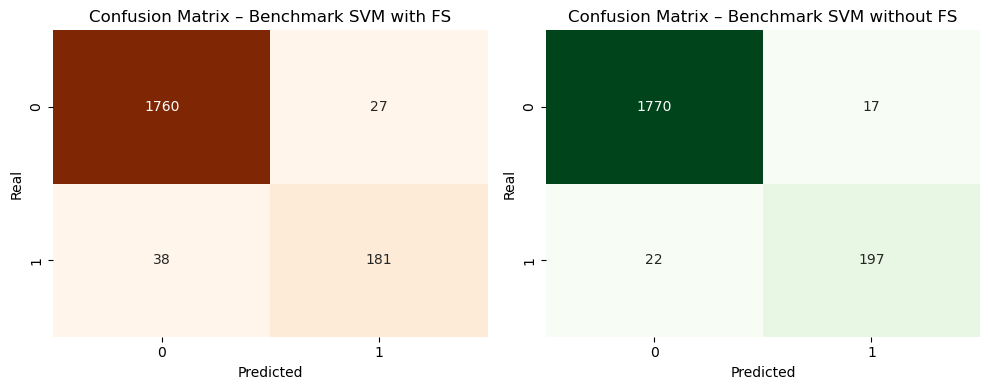

In [108]:
# Plot the confusion matrix for a better visualization of the model's predictions 
cm1 = np.array(conf_sel)

cm2 = np.array(conf)

fig, axes = plt.subplots(1, 2, figsize=(10, 4))  

sns.heatmap(cm1, annot=True, fmt='d', cmap='Oranges', cbar=False,
            xticklabels=[0,1], yticklabels=[0,1], ax=axes[0])
axes[0].set_title("Confusion Matrix – Benchmark SVM with FS")
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("Real")


sns.heatmap(cm2, annot=True, fmt='d', cmap='Greens', cbar=False,
            xticklabels=[0,1], yticklabels=[0,1], ax=axes[1])
axes[1].set_title("Confusion Matrix – Benchmark SVM without FS")
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("Real")

plt.tight_layout()
plt.savefig("../5_SVM/test_performances/Comparison_confusion_matrices.png", dpi=300, bbox_inches="tight")
plt.show()

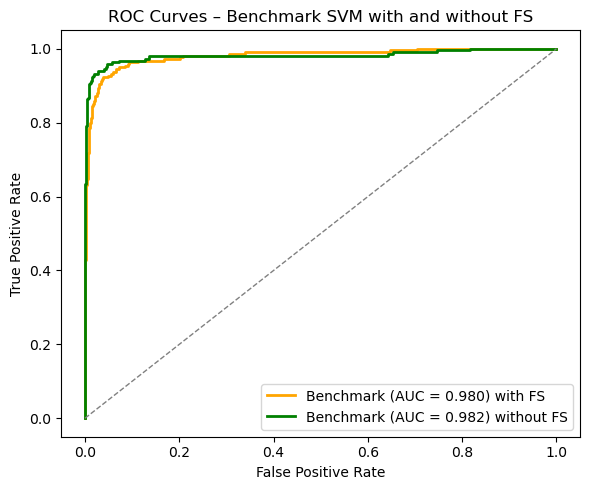

In [109]:
y_scores_1 = final_pipeline_sel.decision_function(x_te_sel.to_numpy())
fpr1, tpr1, _ = roc_curve(Y_T, y_scores_1)
roc_auc1 = auc(fpr1, tpr1)

y_scores_2 = final_pipeline.decision_function(T.to_numpy())
fpr2, tpr2, _ = roc_curve(Y_T, y_scores_2)
roc_auc2 = auc(fpr2, tpr2)

plt.figure(figsize=(6, 5))
plt.plot(fpr1, tpr1, color='orange', lw=2, label=f'Benchmark (AUC = {roc_auc1:.3f}) with FS')
plt.plot(fpr2, tpr2, color='green', lw=2, label=f'Benchmark (AUC = {roc_auc2:.3f}) without FS')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves – Benchmark SVM with and without FS')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig("../5_SVM/test_performances/ROC_comparison_overlay.png", dpi=300, bbox_inches="tight")
plt.show()


In [160]:
full_correct = (y_predict == observed_test).astype(int)
fs_correct   = (y_predictions == observed_test).astype(int)

a = int(((full_correct == 1) & (fs_correct == 1)).sum())  # entrambi corretti
b = int(((full_correct == 1) & (fs_correct == 0)).sum())  # full giusto, fs sbaglia
c = int(((full_correct == 0) & (fs_correct == 1)).sum())  # full sbaglia, fs giusto
d = int(((full_correct == 0) & (fs_correct == 0)).sum())  # entrambi sbagliano

table = [[a, b],
         [c, d]]

print("Contingency (Full rows × FS cols):")
print(pd.DataFrame(table, index=["Full correct","Full wrong"], columns=["FS correct","FS wrong"]))
print(f"b={b}, c={c}, b+c={b+c}")

use_exact = (b + c) < 25
res = mcnemar(table, exact=use_exact, correction=not use_exact)
print(f"statistic={res.statistic}, pvalue={res.pvalue}")

Contingency (Full rows × FS cols):
              FS correct  FS wrong
Full correct        1924        43
Full wrong            17        22
b=43, c=17, b+c=60
statistic=10.416666666666666, pvalue=0.0012488309880884243


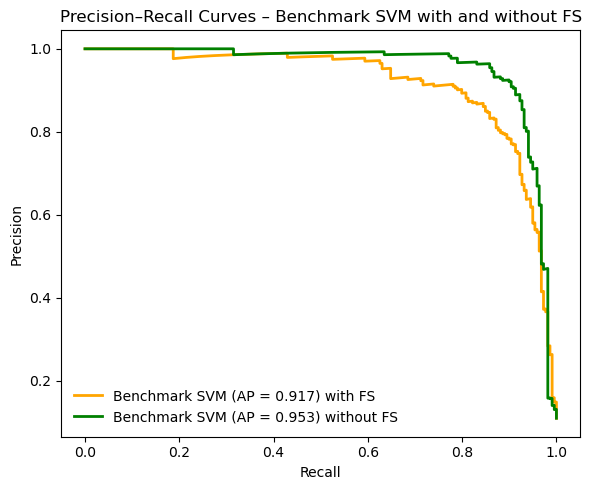

In [110]:
y_scores_1 = final_pipeline_sel.decision_function(x_te_sel.to_numpy())
precision1, recall1, _ = precision_recall_curve(Y_T, y_scores_1)
avg_precision1 = average_precision_score(Y_T, y_scores_1)

y_scores_2 = final_pipeline.decision_function(T.to_numpy())
precision2, recall2, _ = precision_recall_curve(Y_T, y_scores_2)
avg_precision2 = average_precision_score(Y_T, y_scores_2)

plt.figure(figsize=(6, 5))

plt.plot(recall1, precision1, lw=2, color='orange',
         label=f'Benchmark SVM (AP = {avg_precision1:.3f}) with FS')
plt.plot(recall2, precision2, lw=2, color='green',
         label=f'Benchmark SVM (AP = {avg_precision2:.3f}) without FS')


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curves – Benchmark SVM with and without FS')
plt.legend(loc='best', frameon=False)
plt.tight_layout()
plt.savefig("../5_SVM/test_performances/Comparison_precision_recall_curves.png",
            dpi=300, bbox_inches="tight")
plt.show()